<a href="https://colab.research.google.com/github/VladislavTokarev02/AI_ML_homework/blob/main/Hometasks/Base/AI_HW3_Classification_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 3. Линейная классификация. Работа с признаками**

### **Оценивание и штрафы**

Кака всегда - каждая из задач имеет «стоимость» (указана в скобках около задачи).

В задании три части:

- Часть 1 (2.5 балла): написание логистической регрессии своими руками
- Часть 2 (5 баллов): различные методы отбора признаков
- Часть 3 (3.5 балла): обучение моделей классификации на текстах

Всего за задание можно получить 11 баллов, но:

**Балл за задание = min{ваш балл, 10}.**

In [3]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import time
from functools import wraps
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

Populating the interactive namespace from numpy and matplotlib


# **Часть 1. Логистическая регрессия своими руками (2.5 балла)**

## **Задание 1. Реализуйте класс логистической регрессии, обучаемой с помощью:**

**Задание 1.1 (1 балл). Градиентного спуска**

**Задание 1.2 (1 балл). Стохастического градиентного спуска**

До этого вы писали код без ограничений. Здесь же необходимо соблюдать следующие условия:

- Градиентный спуск необходимо записать в векторном виде;
- Циклы средствами python допускается использовать только для итераций градиентного спуска;

**Класс градиентного спуска должен:**
- В качестве критерия останова использовать (одновременно):
  - проверку на евклидову норму разности весов на двух соседних итерациях задаваемого параметром `tolerance`;
  - достижение максимального числа итераций, задаваемого параметром `max_iter`.
- Обладать атрибутом `loss_history`. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту). Данный атрибут необходим, чтобы проследить, что оптимизационный процесс действительно сходится;
- Инициализировать веса случайным образом или нулевым вектором (на ваш выбор).

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

**Шаблон класса описан ниже, вам нужно реализовать каждую из заготовленных функций.**

**ВАЖНО!** Мы заполняем данный шаблон, даже если он нам не нравится. Менять структуру класса и писать по-своему запрещено - за это будут сняты баллы.

In [4]:
import numpy as np
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = None

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        self.loss_history = []

        #инициализируем веса как нули
        if self.w0 is None:
            self.w = np.zeros(X.shape[1])
        else:
            self.w = self.w0.copy()

        for iter_num in range(self.max_iter):
            # Сохраняем предыдущие веса для проверки сходимости
            w_prev = self.w.copy()

            # Считаем текущее значение функции потерь
            current_loss = self.calc_loss(X, y)
            self.loss_history.append(current_loss)

            if self.gd_type == 'stochastic':
                # Случайный индекс для стохастического градиентного спуска
                idx = np.random.randint(X.shape[0])
                grad = self.calc_gradient(X[idx:idx+1], y[idx:idx+1])
            else:
                # Полный градиентный спуск
                grad = self.calc_gradient(X, y)

            # Обновление весов
            self.w = self.w - self.eta * grad

            # Проверка критерия останова
            if np.linalg.norm(self.w - w_prev) < self.tolerance:
                break

        return self


    def predict_proba(self, X):
        """Вычисление вероятностей классов"""
        if self.w is None:
            raise Exception('Not trained yet')
        # Сигмоида: 1 / (1 + exp(-X@w))
        z = X @ self.w
        return 1 / (1 + np.exp(-z))


    def predict(self, X):
        """Предсказание классов"""
        if self.w is None:
            raise Exception('Not trained yet')
        return (self.predict_proba(X) >= 0.5).astype(int)

    def calc_gradient(self, X, y):
        """Вычисление градиента функции потерь
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        # Получаем вероятности для текущих весов
        proba = self.predict_proba(X)
        # Градиент: X^T * (y_pred - y) / n_samples

        return X.T @ (proba - y) / len(y)

    def calc_loss(self, X, y):
        """Вычисление функции потерь (Log loss)
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        eps = 1e-15  # для численной стабильности
        proba = self.predict_proba(X)
        # Log loss: -1/n * sum(y*log(p) + (1-y)*log(1-p))
        return -np.mean(y * np.log(proba + eps) +  (1 - y) * np.log(1 - proba + eps))

Теперь проверим работу вашего класса на синтетических данных.

In [5]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

## **Задание 2 (0.5 балла)**

Обучите логистическую регрессию на синтетических данных.

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

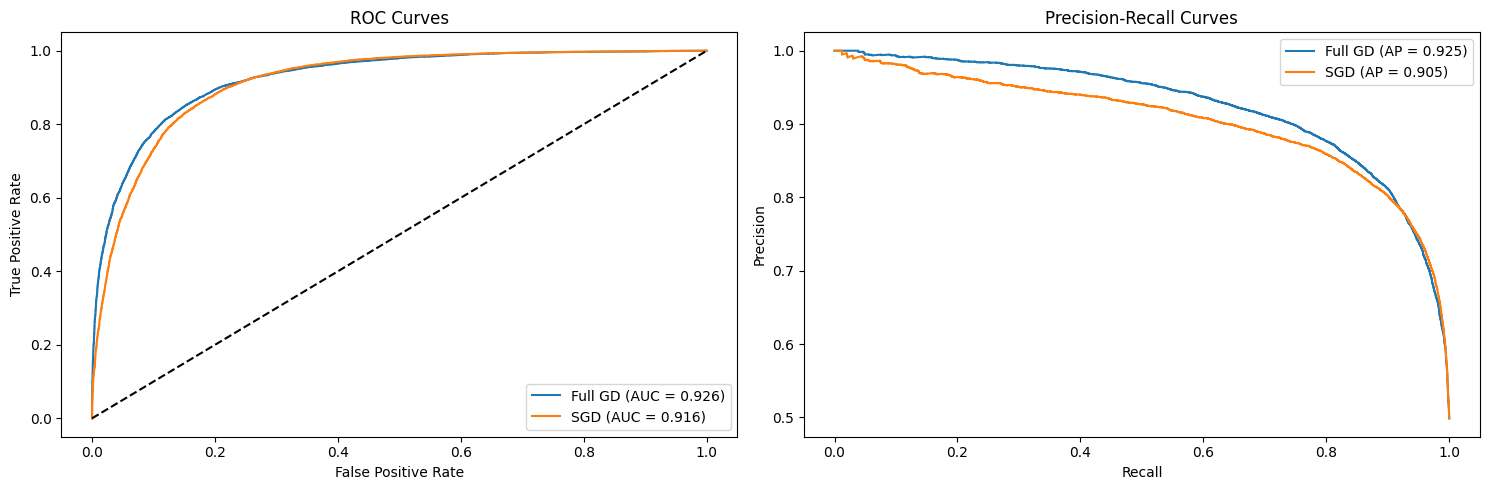

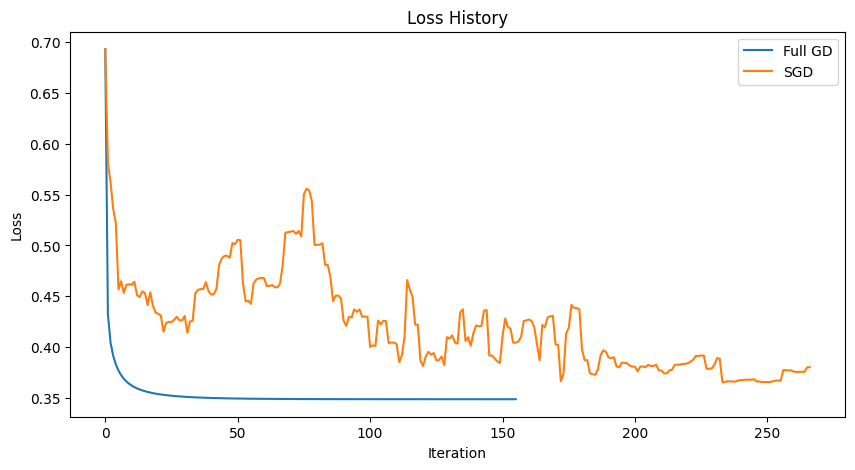

Время обучения Full GD: 1.01 секунд
Время обучения SGD: 0.91 секунд


In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score, average_precision_score
import time

# Обучаем модель с полным градиентным спуском
model_full = LogReg(gd_type='full', eta=0.1, max_iter=1000)
start_time = time.time()
model_full.fit(X_train, y_train)
full_time = time.time() - start_time

# Обучаем модель со стохастическим градиентным спуском
model_sgd = LogReg(gd_type='stochastic', eta=0.01, max_iter=1000)
start_time = time.time()
model_sgd.fit(X_train, y_train)
sgd_time = time.time() - start_time

# Получаем предсказания
y_pred_full = model_full.predict_proba(X_test)
y_pred_sgd = model_sgd.predict_proba(X_test)

# Создаем график с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ROC кривые
fpr_full, tpr_full, _ = roc_curve(y_test, y_pred_full)
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, y_pred_sgd)

ax1.plot(fpr_full, tpr_full, label=f'Full GD (AUC = {roc_auc_score(y_test, y_pred_full):.3f})')
ax1.plot(fpr_sgd, tpr_sgd, label=f'SGD (AUC = {roc_auc_score(y_test, y_pred_sgd):.3f})')
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend()

# PR кривые
precision_full, recall_full, _ = precision_recall_curve(y_test, y_pred_full)
precision_sgd, recall_sgd, _ = precision_recall_curve(y_test, y_pred_sgd)

ax2.plot(recall_full, precision_full,
         label=f'Full GD (AP = {average_precision_score(y_test, y_pred_full):.3f})')
ax2.plot(recall_sgd, precision_sgd,
         label=f'SGD (AP = {average_precision_score(y_test, y_pred_sgd):.3f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend()

plt.tight_layout()
plt.show()

# График функции потерь
plt.figure(figsize=(10, 5))
plt.plot(model_full.loss_history, label='Full GD')
plt.plot(model_sgd.loss_history, label='SGD')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.show()

print(f"Время обучения Full GD: {full_time:.2f} секунд")
print(f"Время обучения SGD: {sgd_time:.2f} секунд")


# **Часть 2. Отбор признаков (5 баллов)**

Перейдём к еще одной важной части процесса работы с данными — отбору признаков. Он нужен в следующих случаях:
- Мы хотим сократить время вычислений;
- Мы хотим избежать переобучения;
- Мы хотим попытаться улучшить качество модели за счет уменьшения признакового пространства;

В этой части мы попробуем применить несколько подходов для отбора признаков и оценим, как они влияют на качество модели и сколько времени занимают.

**Данные** \

Будем использовать датасет [об обращениях клиентов по страховым случаям](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data?select=train.csv). Скачайте его с Kaggle (файл `train.csv`).

Задача представляет собой бинарную классификациюю — воспользуется ли клиент страховкой на авто в ближайший год.

In [7]:
PATH_TO_DATASET = 'train.csv'

data = pd.read_csv(PATH_TO_DATASET, index_col=0)
target = data.target.values

data = data.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

### **Задание 3. (0.25 балла)**

Прежде всего — в данных много категориальных признаков.

- Закодируйте их с помощью one-hot кодирования. Категориальные признаки отмечены постфиксом `cat`;
- Исходные колонки с категориальными признаками удалите;
- Зафиксируйте, сколько признаков получилось;

In [8]:
print(f'Размерность признакового пространства до преобразования OneHotEncoder: {X_train.shape[1]}')


cat_cols = [col for col in data.columns if col.endswith('cat')]
other_cols = data.loc[:, ~data.columns.isin(cat_cols)]

print(f'Количество категориальных признаков по постфикcу _cat: {len(cat_cols)}')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), cat_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

X_train = pd.DataFrame(X_train_transformed, columns = preprocessor.get_feature_names_out())
X_test = pd.DataFrame(X_test_transformed, columns = preprocessor.get_feature_names_out())

print(f'Размерность признакового пространства после преобразования OneHotEncoder: {X_train.shape[1]}')

Размерность признакового пространства до преобразования OneHotEncoder: 57
Количество категориальных признаков по постфикcу _cat: 14
Размерность признакового пространства после преобразования OneHotEncoder: 213


### **Задание 4 (1 балл)**

Обучим несколько моделей, перечисленных ниже. В качестве метрики будем использовать ROC-AUC.

**Задание 4.1**

- Обучите модель логистической регрессии. Замерьте скорость обучения модели
- Обучите метод опорных векторов
- Обучите метод k ближайших соседей
- Посчитайте качество моделей (ROC-AUC) на тестовой выборке

**Задание 4.2**

Для каждой из трех моделей (логистическая регрессия, SVM, KNN) подберите при помощи GridSearchCV на тренировочных данных оптимальные гиперпараметры:
- Для логистической регрессии: C, class_weight
- Для SVM: C, kernel, class_weight
- Для KNN: n_neighbors, weights

Затем посчитайте качество моделей на тестовой выборке.

В заданиях 4.1 и 4.2 замеряйте время обучения моделей.


### Задание 4.1

In [ ]:
def measure_time(func):
  @wraps(func) # при помощи данного метода мы сохраняем метаданные исходной функции, которые в противном случае потеряются при использовании декоратора
  def wrapper(*args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    duration = end_time - start_time
    print(f'Время работы алгоритма {func.__name__} составляет {duration:.2f} секунд')
    return result
  return wrapper

In [ ]:
@measure_time
def logistic_regression():
  lr = LogisticRegression(random_state = 42, max_iter = 500) #max_iter нужен для контроля количества итераций, по дефолту в sklearn - 100.
  lr.fit(X_train, y_train)
  y_pred = lr.predict_proba(X_test)[:, 1] # предсказываем вероятность для положительного класса
  result = round(roc_auc_score(y_test, y_pred), 2)
  return result

logistic_regression()

Время работы алгоритма logistic_regression составляет 24.36 секунд


0.64

In [ ]:
@measure_time
def SVM():
  svc = LinearSVC(random_state = 42)
  svc.fit(X_train, y_train)
  y_pred = svc.predict(X_test)
  result = roc_auc_score(y_test, y_pred)
  return result

SVM()

Время работы алгоритма SVM составляет 28.62 секунд


0.5

In [ ]:
@measure_time
def knn():
  knn = KNeighborsClassifier()
  knn.fit(X_train, y_train)
  y_pred = knn.predict_proba(X_test)[:, 1]
  result = roc_auc_score(y_test, y_pred)
  return result

knn()

Время работы алгоритма knn составляет 87.34 секунд


0.5091952843544416

### Задание 4.2

In [ ]:
params_lr = {
    'C' : [0.001, 0.01, 0.1, 1, 10], # чем меньше C, тем сильнее регуляризация
    'class_weight' : [None, 'balanced'] # баланс на веса, 'balanced' автоматически вычисляет веса классов, чтобы сбалансировать влияние каждого класса на обучение
}
start_time = time.time()
gs_lr = GridSearchCV(LogisticRegression(random_state = 42, max_iter = 500), params_lr, cv = 3, verbose = 0, n_jobs = -1, scoring = 'roc_auc')
gs_lr.fit(X_train, y_train)
end_time = time.time()
diff_lr = end_time - start_time

print(f'Лучший score: {gs_lr.best_score_}')
print(f'Лучшие параметры модели: {gs_lr.best_params_}')
print(f'GridSearchCV на логистической регрессии занял {diff_lr:.2f} секунд')

Лучший score: 0.6269060198223604
Лучшие параметры модели: {'C': 0.001, 'class_weight': 'balanced'}
GridSearchCV на логистической регрессии занял 1203.73 секунд


В виду того, что подбирать оптимальные гиперпараметры для SVC будет очень долго, попробуем обучить на сэмпле из 20000 объектов.

In [ ]:
np.random.seed(42)

# Получаем случайные индексы для подвыборки
n_samples = 20000
total_samples = X_train.shape[0]
subsample_idx = np.random.choice(total_samples, n_samples, replace=False)

# Создаем подвыборку с использованием iloc
X_train_sub = X_train.iloc[subsample_idx]
y_train_sub = y_train[subsample_idx]

print(f"Размер исходной выборки: {X_train.shape}")
print(f"Размер подвыборки: {X_train_sub.shape}")


params_svc = {
    'C' : [0.001, 0.01, 0.1], # чем меньше C, тем сильнее регуляризация
    'class_weight' : [None, 'balanced'], # баланс на веса, 'balanced' автоматически вычисляет веса классов, чтобы сбалансировать влияние каждого класса на обучение
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']
}


start_time = time.time()
gs_svc = GridSearchCV(SVC(random_state = 42), params_svc, cv = 3, verbose = 0, n_jobs = -1, scoring = 'roc_auc')
gs_svc.fit(X_train_sub, y_train_sub)
end_time = time.time()
diff_lr = end_time - start_time

print(f'Лучший score (на 20000 объектах): {gs_svc.best_score_}')
print(f'Лучшие параметры модели (на 20000 объектах): {gs_svc.best_params_}')
print(f'GridSearchCV на SVC занял (на 20000 объектах): {diff_lr:.2f} секунд')

Размер исходной выборки: (476169, 213)
Размер подвыборки: (20000, 213)
Лучший score (на 20000 объектах): 0.6118073494939495
Лучшие параметры модели (на 20000 объектах): {'C': 0.01, 'class_weight': 'balanced', 'kernel': 'linear'}
GridSearchCV на SVC занял (на 20000 объектах): 232.22 секунд


In [ ]:
params_knn = {
    'n_neighbors' : [4, 6, 8, 10],
    'weights' : ['uniform', 'distance']
}

start_time = time.time()
gs_knn = GridSearchCV(KNeighborsClassifier(), params_knn, cv = 3, verbose = 2, n_jobs = -1, scoring = 'roc_auc')
gs_knn.fit(X_train, y_train)
end_time = time.time()
diff_lr = end_time - start_time

print(f'Лучший score: {gs_knn.best_score_}')
print(f'Лучшие параметры модели: {gs_knn.best_params_}')
print(f'GridSearchCV на KNN: {diff_lr:.2f} секунд')

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Лучший score: 0.5176114483977372
Лучшие параметры модели: {'n_neighbors': 10, 'weights': 'distance'}
GridSearchCV на KNN: 6160.81 секунд


### **Встроенные методы**

**Заметим, что:**

- Время обучения моделей отличается между собой.
- Несмотря на то, что признаков много, качество модели не очень хорошее.


Попробуем решить проблемы — улучшить качество и при этом сократить пространство признаков и, соответственно, время обучения моделей.



**Отбор признаков встроеным методом.**

Начнём с отбора признаков с помощью линейной модели. Делая это, мы используем факт:
> веса линейной модели отражают  вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков.

Такой метод отбора называются встроенным в модель методом, так как он заложен в особенности модели.

**Важно:** применение этого подхода требует машстабирования признаков (подумайте, почему). Вы можете использовать приведение к стандартному нормальному распределению (`StandardScaler`) с параметрами или MinMax преобразование (`MinMaxScaler`).

### **Задание 5 (0.75 балла)**

Оставьте 150 признаков с наибольшими по модулю весами после обучения логистической регрессии.

- Замерьте скорость такого отбора признаков. (0.2 балла)

- Обучите логистическую регрессию на исходных признаках. Из них оставьте 150 лучших (с наибольшими по модулю весами).
- Масштабируйте данные — все, кроме категориальных и бинарных признаков. Зафиксируйте, сколько признаков пришлось масштабировать. (0.25 балла)
- Обучите новую модель на 150 признаках и оцените её качество. (0.15 балла)




In [7]:
start_time = time.time()
lr = LogisticRegression(random_state = 42, max_iter = 1000)
lr.fit(X_train, y_train)
end_time = time.time()

feature_importance = np.abs(lr.coef_[0])
top_150 = np.argsort(feature_importance)[-150:]

X_train_selected_150 = X_train.iloc[:, top_150]
X_test_selected_150 = X_test.iloc[:, top_150]


# Определяем категориальные и бинарные признаки
# (признаки, у которых только 1 или 2 уникальных значения)
binary_cat_mask = X_train_selected_150.nunique().isin([1, 2]).values
features_to_scale = ~binary_cat_mask


scaler = StandardScaler()
X_train_scaled = X_train_selected_150.copy()
X_test_scaled = X_test_selected_150.copy()

if np.any(features_to_scale):
    X_train_scaled.iloc[:, features_to_scale] = scaler.fit_transform(X_train_selected_150.iloc[:, features_to_scale])
    X_test_scaled.iloc[:, features_to_scale] = scaler.transform(X_test_selected_150.iloc[:, features_to_scale])


final_lr = LogisticRegression(random_state=42)
final_lr.fit(X_train_scaled, y_train)


final_score = roc_auc_score(y_test, final_lr.predict_proba(X_test_scaled)[:, 1])

end_time = time.time()

diff = end_time - start_time
print(f'Время, затраченное на обучение логистической регрессии составляет: {diff:.2f} секунд')
print(f"Количество масштабированных признаков: {np.sum(features_to_scale)}")
print(f"ROC-AUC на тестовой выборке: {final_score:.4f}")

Время, затраченное на обучение логистической регрессии составляет: 37.87 секунд
Количество масштабированных признаков: 7
ROC-AUC на тестовой выборке: 0.6358


### **Бонус (0.25 балла)**

Попробуйте реализовать итеративный отбор признаков, а именно:

1) Сначала отобрать около 200 признаков (действуя как в задании выше)

2) Потом повторить процедуру для отбора 150 признаков из 200 (снова действуя как в задании выше)

In [9]:
start_time = time.time()


base_lr = LogisticRegression(random_state=42, max_iter=500)
base_lr.fit(X_train, y_train)


feature_importance = np.abs(base_lr.coef_[0])
top_200_idx = np.argsort(feature_importance)[-200:]


X_train_200 = X_train.iloc[:, top_200_idx]
X_test_200 = X_test.iloc[:, top_200_idx]


second_lr = LogisticRegression(random_state=42, max_iter=500)
second_lr.fit(X_train_200, y_train)


feature_importance_2 = np.abs(second_lr.coef_[0])
top_150_idx = np.argsort(feature_importance_2)[-150:]


X_train_selected = X_train_200.iloc[:, top_150_idx]
X_test_selected = X_test_200.iloc[:, top_150_idx]


binary_cat_mask = X_train_selected.nunique().isin([1, 2]).values
features_to_scale = ~binary_cat_mask


scaler = StandardScaler()
X_train_scaled = X_train_selected.copy()
X_test_scaled = X_test_selected.copy()

if np.any(features_to_scale):
    X_train_scaled.iloc[:, features_to_scale] = scaler.fit_transform(X_train_selected.iloc[:, features_to_scale])
    X_test_scaled.iloc[:, features_to_scale] = scaler.transform(X_test_selected.iloc[:, features_to_scale])

final_lr = LogisticRegression(random_state=42)
final_lr.fit(X_train_scaled, y_train)


final_score = roc_auc_score(y_test, final_lr.predict_proba(X_test_scaled)[:, 1])


total_time = time.time() - start_time

print(f"Время выполнения: {total_time:.2f} секунд")
print(f"Количество масштабированных признаков: {np.sum(features_to_scale)}")
print(f"ROC-AUC на тестовой выборке: {final_score:.4f}")


final_feature_indices = top_200_idx[top_150_idx]
print(f"\nКоличество общих признаков с предыдущим подходом: "
      f"{np.sum(np.isin(final_feature_indices, top_150_idx))}")

Время выполнения: 44.78 секунд
Количество масштабированных признаков: 8
ROC-AUC на тестовой выборке: 0.6357

Количество общих признаков с предыдущим подходом: 106


### **Задание 6 (0.5 балла)**

Также можно задать отбор признаков, используя другия свойства модели. Вспомним, что L1-регуляризация тоже умеет отбирать признаки.

- Обучите модель на исходных данных. Подберите по сетке (GridSearch) наилучшее значение коэффициента регуляризации C. (0.1 балла)

- Посмотрите сколько признаков отобрала модель с найденным оптимальным C?
  - Сначала посчитайте только число ненулевых весов
  - Затем посчитайте число весов, которые после округления до двух знаков после запятой не равны нулю (0.25 балла)

Удалось ли отобрать 150 признаков за 1 шаг? (0.05 балла)

In [13]:
params = {
    'C' : np.logspace(-4, 4, 20) # от 10^-4 до 10^4, 20 точек
}

gs_lr_l1 = GridSearchCV(LogisticRegression(random_state = 42, penalty = 'l1', solver = 'saga'), cv = 4, param_grid = params, verbose =0, scoring = 'roc_auc', n_jobs = -1)
start_time = time.time()
gs_lr_l1.fit(X_train, y_train)

best_model = gs_lr_l1.best_estimator_

print("Лучшее значение C:", gs_lr_l1.best_params_['C'])
print("Лучший ROC-AUC на кросс-валидации:", gs_lr_l1.best_score_)

# Считаем количество ненулевых весов
non_zero_weights = np.sum(best_model.coef_[0] != 0)
print("\nКоличество ненулевых весов:", non_zero_weights)


rounded_non_zero = np.sum(np.round(best_model.coef_[0], 2) != 0)
print("Количество ненулевых весов после округления до 2 знаков:", rounded_non_zero)


test_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
end_time = time.time()
total_time = end_time - start_time


print(f'Время выполнения алгоритма LogReg+L1 составила: {total_time:.2f} секунд')
print("\nROC-AUC на тестовой выборке:", test_score)

Лучшее значение C: 0.23357214690901212
Лучший ROC-AUC на кросс-валидации: 0.6272484833250752

Количество ненулевых весов: 166
Количество ненулевых весов после округления до 2 знаков: 150
Время выполнения алгоритма LogReg+L1 составила: 707.98 секунд

ROC-AUC на тестовой выборке: 0.6386593317939799


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### **Методы фильтрации**

Также можно отбирать признаки, применяя методы математической статистики. А именно, в нашем случае, через подсчёт некоторой функции для каждого признака. На основании значений этой функции (она называется *статистикой*) мы можем оставлять наиболее важные признаки. Методы этого семейства называют *фильтрационными* или *filter methods*.

**Что проверяем:**

Равны ли математические ожидания (то есть выборочные средние) распределений признака для двух разных классов? Если они различаются, значит и сами распределения разные. И можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и значение статистики маленькое, то и признак бесполезен.


Для проверки будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ s^2_+ + n_- s^2_-}{n_+ + n_-}}},$$

где $\mu$, $s$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

**Примечание:** Если у вас была данная тема на курсе по математической статистике, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях.

Хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и $n$ велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются.

Для отбора признаков по t-статистике мы возьмём признаки с наибольшим значением статистики.

### **Задание 7 (1 балла)**

-  Масштабируйте признаки исходного датасета — все, кроме категориальных и бинарных.
- Выделите непрерывные признаки (те, которые масштабировали)
- Посчитайте значения t-статистики. Оставьте ***половину*** признаков с наибольшим значением статистики, объедините их с категориальными и бинарными.
- Обучите модель логистической регрессии и замерьте качество.

Не забудьте замерить скорость отбора признаков в этом случаев.

In [20]:
def calculate_t_statistic(X, y, feature_idx):
    """
    Вычисляет t-статистику для заданного признака по формуле:
    t(x) = |μ+ - μ-| / sqrt((n+ * s²+ + n- * s²-) / (n+ + n-))
    где μ - среднее, s² - дисперсия, n - количество объектов каждого класса

    Parameters:
    -----------
    X : pd.DataFrame
        Матрица признаков
    y : np.array
        Целевая переменная (0 или 1)
    feature_idx : int
        Индекс признака для расчета

    Returns:
    --------
    float
        Значение t-статистики
    """
    # Разделяем данные по классам
    pos_samples = X.iloc[y == 1, feature_idx]
    neg_samples = X.iloc[y == 0, feature_idx]

    # Считаем статистики для каждого класса
    mu_pos, mu_neg = np.mean(pos_samples), np.mean(neg_samples)
    var_pos, var_neg = np.var(pos_samples, ddof=0), np.var(neg_samples, ddof=0)
    n_pos, n_neg = len(pos_samples), len(neg_samples)

    # Считаем t-статистику
    pooled_se = np.sqrt((n_pos * var_pos + n_neg * var_neg) / (n_pos + n_neg))
    t_stat = np.abs(mu_pos - mu_neg) / pooled_se

    return t_stat

In [21]:
start_time = time.time()

# Определяем непрерывные признаки (для масштабирования)
# Используем признаки с более чем 2 уникальными значениями, т.к.
# все категориальные признаки уже были преобразованы в бинарные OneHotEncoder
continuous_features = []
for col in range(X_train.shape[1]):
    if X_train.iloc[:, col].nunique() > 2:
        continuous_features.append(col)

# Масштабируем непрерывные признаки
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

if continuous_features:  # если есть непрерывные признаки, масштабируем
    X_train_scaled.iloc[:, continuous_features] = scaler.fit_transform(X_train.iloc[:, continuous_features])
    X_test_scaled.iloc[:, continuous_features] = scaler.transform(X_test.iloc[:, continuous_features])

# Считаем t-статистику для непрерывных признаков
t_statistics = [
    (idx, calculate_t_statistic(X_train_scaled, y_train, idx))
    for idx in continuous_features
]

# Сортируем по t-статистике
t_statistics.sort(key=lambda x: x[1], reverse=True)

# Берем половину непрерывных признаков с наибольшей t-статистикой
selected_continuous = [idx for idx, _ in t_statistics[:len(continuous_features)//2]]

# Добавляем бинарные и категориальные признаки
binary_categorical = list(set(range(X_train.shape[1])) - set(continuous_features))
final_features = sorted(selected_continuous + binary_categorical)

# Формируем итоговый датасет
X_train_final = X_train_scaled.iloc[:, final_features]
X_test_final = X_test_scaled.iloc[:, final_features]

lr = LogisticRegression(random_state=42)
lr.fit(X_train_final, y_train)

test_score = roc_auc_score(y_test, lr.predict_proba(X_test_final)[:, 1])

total_time = time.time() - start_time

print(f"Время выполнения: {total_time:.2f} секунд")
print(f"Количество отобранных признаков: {len(final_features)}")
print(f"ROC-AUC на тестовой выборке: {test_score:.4f}")

Время выполнения: 4.38 секунд
Количество отобранных признаков: 200
ROC-AUC на тестовой выборке: 0.6378


### **Методы-обёртки**

### **Задание 8 (бонус, 1 балл)**


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди каждый из признаков и смотрим, как это влияет на качество модели, обученной без удаленного признака. Удаляем признаки таким жадным способом.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур много. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо.

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 150 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [10]:
def evaluate_without_feature(X_train, X_val, y_train, y_val, feature_to_remove):
    """
    Оценивает качество модели без указанного признака

    Parameters:
    -----------
    X_train, X_val : pd.DataFrame
        Обучающая и валидационная выборки
    y_train, y_val : np.array
        Целевые переменные
    feature_to_remove : int
        Индекс признака для удаления

    Returns:
    --------
    float
        ROC-AUC на валидационной выборке
    """
    # Создаем копии данных без указанного признака
    X_train_subset = X_train.drop(X_train.columns[feature_to_remove], axis=1)
    X_val_subset = X_val.drop(X_val.columns[feature_to_remove], axis=1)

    # Обучаем модель
    model = LogisticRegression(random_state=42, max_iter=700)
    model.fit(X_train_subset, y_train)

    # Оцениваем качество
    return roc_auc_score(y_val, model.predict_proba(X_val_subset)[:, 1])

На подвыборке в 10000 объектов.

In [11]:
# Основной код
start_time = time.time()

# Берем подвыборку для ускорения процесса
sample_size = 10000
indices = np.random.choice(len(X_train), sample_size, replace=False)
X_sample = X_train.iloc[indices]
y_sample = y_train[indices]

# Разделяем выборку на обучающую и валидационную
X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_sample, y_sample, test_size=0.3, random_state=42
)

# Параметры
n_features_to_check = 10  # количество признаков для проверки в одной итерации

# Получаем случайную подвыборку признаков для проверки
available_features = list(range(X_train_transformed.shape[1]))
features_to_check = np.random.choice(
    available_features,
    size=min(n_features_to_check, len(available_features)),
    replace=False
)

# Оцениваем качество без каждого признака из выбранного набора
feature_scores = []
for feature_idx in features_to_check:
    score = evaluate_without_feature(
        X_train_part, X_val, y_train_part, y_val, feature_idx
    )
    feature_scores.append((feature_idx, score))

    # Выводим прогресс
    if (len(feature_scores)) % 10 == 0:
        print(f"Обработано признаков: {len(feature_scores)}")
        print(f"Прошло времени: {time.time() - start_time:.2f} секунд")

# Сортируем признаки по качеству (чем ниже качество без признака, тем важнее признак)
feature_importance = sorted(feature_scores, key=lambda x: x[1], reverse=True)

# Выводим результаты одной итерации
total_time = time.time() - start_time
print(f"\nРезультаты одной итерации на подвыборке 10000 объектов:")
print(f"Время выполнения: {total_time:.2f} секунд")
print(f"Проверено признаков: {len(feature_scores)}")
print(f"Среднее время на один признак: {total_time/len(feature_scores):.2f} секунд")

# Оцениваем полное время для проверки всех признаков
total_features = X_train_transformed.shape[1]
estimated_total_time = 11466 * total_time/len(feature_scores)

print(f"\nОценка полного времени: отсутствует, т.к. слишком долго")
print(f"Всего признаков: {total_features}")
print(f"Оценочное время полного перебора: {estimated_total_time/60:.1f} минут")

Обработано признаков: 10
Прошло времени: 3.73 секунд

Результаты одной итерации на подвыборке 10000 объектов:
Время выполнения: 3.73 секунд
Проверено признаков: 10
Среднее время на один признак: 0.37 секунд

Оценка полного времени: отсутствует, т.к. слишком долго
Всего признаков: 213
Оценочное время полного перебора: 71.2 минут


Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


### **Задание 9 (0.25 балла)**

Подведите итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

#### Итоги:

Общая постановка задачи: отобрать 150 признаков, которые наилучшим образом предсказывают целевую переменную. Оценить затраты (время) и качество.

##### Опробованные методы (сводка):
  
| Метод                                                     | Время выполнения        | ROC-AUC на тесте     | Примечание |
|----------------------------------------------------------|-------------------------|-----------------------|------------|
| Отбор по весам линейной регрессии (задание 5)           | 37.87 секунд                | 0.6358                |            |
| Двойной отбор по весам линейной регрессии (5.бонус)     |  59.84 секунды               | 0.6358               |            |
| Отбор по весам линейной регрессии с L1-регуляризацией (задание 6) | 707.98  секунд             | 0.6386                |            |
| Отбор на основе t-статистики (задание 7)          | 4.38 секунды             | 0.6378                | не требуется обучения модели |
| Отбор признаков жадной стратегией на подвыборке 10000 объектов (задание 8) | 71.2 минуты             | -                |  |

##### Особенности методов:
Задание 5: Отбор по весам логистической регрессии
- Простой и быстрый метод
- Требует предварительного масштабирования признаков
- Учитывает только линейные зависимости

Задание 6: L1-регуляризация
- Лучшее качество среди всех методов
- Автоматически определяет количество признаков
- Требует подбора параметра регуляризации, но в целом очень быстрый

Задание 7: Метод фильтрации (t-статистика)
- Самый быстрый метод
- Не зависит от модели
- Простая интерпретация результатов

Задание 8: Метод-обертка
- Время на подвыборке (10000 объектов): 67.4 минуты
Особенности:
- Очень высокая вычислительная сложность
- качество худшее из полученных

##### Практические рекомендации:
- Для быстрого результата: t-статистика
- Для лучшего качества: L1-регуляризация
- Для интерпретируемости: Отбор по весам
- Метод-обертку в таком виде ("жадный") использовать не имеет смысла

#### Важные выводы:
- Простые методы часто работают лучше сложных
- Необходимо учитывать компромисс время/качество
- Предварительное масштабирование признаков критично
- Разные методы дают схожие результаты по качеству

# **Часть 3. Обучение моделей на текстовых данных. (3.5 балла)**

 ### **Подготовка данных из реального мира.**

Загрузите данные с конкурса  [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv) (вам нужна только обучающая выборка, файл `train.csv`). Задача состоит в определении постов, сообщающих о чрезвычайной ситуации. В рамках домашнего задания, этот набор данных будет отличным полем для тренировки в обработке признаков.

In [14]:
!pip install nltk

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [61]:
from sklearn.model_selection import train_test_split

PATH = 'train_NLP.csv'
data = pd.read_csv(PATH)

data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [57]:
data.shape

(7613, 5)

### **Задание 10. Базовая предобработка (0.5 баллов).**

- Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [58]:
data.isna().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


In [62]:
data = data.fillna('')

- Проанализируйте количество уникальных значений в числовых столбцах. Сделайте выводы.

In [44]:
data[['id', 'target']].nunique()

,0
id,7613
target,2


- Проанализируйте соотношение классов в целевой переменной. Почему значимо это учитывать?

In [45]:
data['target'].value_counts(normalize = True)

,proportion
target,
0,0.57034
1,0.42966


При решении задачи классификации очень важно учитывать баланс/дисбаланс классов

- Объедините все три текстовых столбца в один (вам поможет конкатенация строк)

In [63]:
data[['keyword', 'location', 'text']] = data[['keyword', 'location', 'text']].astype('str')
data['sum_text'] = data[['keyword', 'location', 'text']].apply(' '.join, axis = 1)
data = data[['id', 'sum_text', 'target']]

- Наконец, поделите данные на тренировочную и тестовую выборки.

In [64]:
X = data['sum_text']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25, stratify = y)
#stratify = y нужен для того, чтобы сохранить изначальный баланс классов в таргете.

### **Задание 11. Базовые модели. (1 балл).**

Данные, собираемые с сайтов, часто содержат мусор не информативный для моделей. Посмотрите, какого качества данные здесь. Для этого:
- Примените CountVectorizer из sklearn к сырым даным. Какого размера получилась матрица?

In [65]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f'Размерность X_train до векторизации составляет: {X_train.shape}, тогда как после: {X_train_vec.shape}')
print(f'Размерность X_test до векторизации составляет: {X_test.shape}, тогда как после: {X_test_vec.shape}')
print(f'Количество уникальных токенов составляет: {len(vectorizer.vocabulary_)}')

Размерность X_train до векторизации составляет: (5709,), тогда как после: (5709, 19380)
Размерность X_test до векторизации составляет: (1904,), тогда как после: (1904, 19380)
Количество уникальных токенов составляет: 19380


- Обучите логистическую регрессию на полученном наборе. Какое качество `f1` у модели получилось на тестовых данных?

In [70]:
start_time = time.time()
log_reg = LogisticRegression(random_state = 42)
log_reg.fit(X_train_vec, y_train)
y_pred = log_reg.predict(X_test_vec)

f1_sc = f1_score(y_test, y_pred)

end_time = time.time()
time_diff = end_time - start_time

print(f'f1_score на тестовых данных логистической регрессии составляет: {f1_sc:.4f}')
print(f'Время выполнения логистической регрессии: {time_diff:.2f} секунд')

f1_score на тестовых данных логистической регрессии составляет: 0.7738
Время выполнения логистической регрессии: 6.37 секунд


- Обучите SVC на тех же данных с гиперпараметрами по умолчанию. Измерьте качество (`f1`) на тестовых данных и опишите результат. Проанализируйте качество и скорость обучения.

In [71]:
start_time = time.time()
svc = SVC(random_state = 42)
svc.fit(X_train_vec, y_train)
y_pred = svc.predict(X_test_vec)

f1_sc = f1_score(y_test, y_pred)

end_time = time.time()
diff_time = end_time - start_time

print(f'f1_score на тестовых данных логистической регрессии составляет: {f1_sc:.4f} секунд')
print(f'Время выполнения SupportedVectorClassifier: {time_diff:.2f} секунд')

f1_score на тестовых данных логистической регрессии составляет: 0.7565 секунд
Время выполнения SupportedVectorClassifier: 6.37 секунд


### **Задание 12. Улучшение базовых моделей за счет данных. (0.5 балла).**

- Подберите гиперпараметры CountVectorizer так, чтобы признаков было минимум в 4 раза меньше, чем объектов, а качество модели при этом изменилось не более чем на $\pm 0.07$. Опишите подобранные гиперпараметры и на что они влияют (0.5 балла).

Обучайте и логистическую регрессию, и SVC.

In [84]:
start_time = time.time()

vectorizer_upg = CountVectorizer(
    max_features = 4500, # Максимальное число столбцов в итоговом варианте
    min_df = 5, # Игнорировать термины, встречающиеся менее чем в 2 документах
    max_df = 0.95, # Игнорировать термины, встречающиеся в более чем 85% документов
    ngram_range=(1, 3), # Используем биграммы или триграммы
    stop_words = 'english' # Исключаем стоп-слова в английском языке
)

X_train_vec_upg = vectorizer_upg.fit_transform(X_train)
X_test_vec_upg = vectorizer_upg.transform(X_test)

end_time = time.time()
diff_time = end_time - start_time

print(f'Размерность X_train до векторизации составляет: {X_train.shape}, тогда как после: {X_train_vec_upg.shape}')
print(f'Размерность X_test до векторизации составляет: {X_test.shape}, тогда как после: {X_test_vec_upg.shape}')
print(f'Количество уникальных токенов составляет: {len(vectorizer_upg.vocabulary_)}')
print(f'Время, необходимое для CountVectorizer с гиперпараметрами: {diff_time:.2f} секунд')

Размерность X_train до векторизации составляет: (5709,), тогда как после: (5709, 3703)
Размерность X_test до векторизации составляет: (1904,), тогда как после: (1904, 3703)
Количество уникальных токенов составляет: 3703
Время, необходимое для CountVectorizer с гиперпараметрами: 0.59 секунд


Логистическая регрессия после подбора гиперпараметров у CountVectorizer.

In [85]:
start_time = time.time()
log_reg = LogisticRegression(random_state = 42)
log_reg.fit(X_train_vec_upg, y_train)
y_pred = log_reg.predict(X_test_vec_upg)

f1_sc = f1_score(y_test, y_pred)

end_time = time.time()
time_diff = end_time - start_time

print(f'f1_score на тестовых данных логистической регрессии составляет (CountVectorizer с гиперпараметрами): {f1_sc:.4f}')
print(f'Время выполнения логистической регрессии: {time_diff:.2f} секунд')

f1_score на тестовых данных логистической регрессии составляет (CountVectorizer с гиперпараметрами): 0.7549
Время выполнения логистической регрессии: 0.05 секунд


In [87]:
start_time = time.time()
svc = SVC(random_state = 42)
svc.fit(X_train_vec_upg, y_train)
y_pred = svc.predict(X_test_vec_upg)

f1_sc = f1_score(y_test, y_pred)

end_time = time.time()
diff_time = end_time - start_time

print(f'f1_score на тестовых данных логистической регрессии составляет (CountVectorizer с гиперпараметрами): {f1_sc:.4f} секунд')
print(f'Время выполнения SupportedVectorClassifier: {time_diff:.2f} секунд')

f1_score на тестовых данных логистической регрессии составляет (CountVectorizer с гиперпараметрами): 0.7438 секунд
Время выполнения SupportedVectorClassifier: 0.05 секунд


### **Задание 13. Улучшение базовых моделей путем подбора гиперпараметров. (1 балл).**
- Попробуйте подбирать разные гиперпараметры для логистической регрессии. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [ ]:
start_time = time.time()

params = {
    'C': [0.001, 0.01, 1, 10],
    'solver': ['lbfgs', 'liblinear', 'saga'], # 'newton-cg' и 'saga' конфликтуют с некоторыми penalties
    'penalty': ['l1', 'l2', 'elasticnet']  # Добавляем только поддерживаемые значения
}

gs_lr = GridSearchCV(LogisticRegression(random_state = 42, max_iter = 1000), n_jobs = 1, verbose = 1, param_grid = params, cv = 5,
                     scoring = 'f1')
gs_lr.fit(X_train_vec_upg, y_train)
lr_best_pred = gs_lr.predict(X_test_vec_upg)

end_time = time.time()
diff_time = end_time - start_time


print(f'Лучшие параметры для логистической регрессии: {gs_lr.best_params_}')
print(f'Лучший результат f1 для логистической регрессии: {gs_lr.best_score_}')
print(f"f1 на тестовой выборке: {f1_score(y_test, lr_best_pred):.4f}")
print(f'Время подбора гиперпараметров для логистической регрессии по сетке: {diff_time:.2f} секунд')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

- Попробуйте подбирать разные гиперпараметры для модели SVC. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [ ]:
params_svc = {
    'C' : [0.001, 0.01, 0.1], # чем меньше C, тем сильнее регуляризация
    'class_weight' : [None, 'balanced'], # баланс на веса, 'balanced' автоматически вычисляет веса классов, чтобы сбалансировать влияние каждого класса на обучение
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']
}

gs_lr = GridSearchCV(SVC(random_state = 42), n_jobs = 1, verbose = 1, param_grid = params_svc, cv = 5, scoring = 'f1')
gs_lr.fit(X_train_vec_upg, y_train)
lr_best_pred = gs_lr.predict(X_test_vec_upg)


print(f'Лучшие параметры для логистической регрессии: {gs_lr.best_params_}')
print(f'Лучший результат f1 для логистической регрессии: {gs_lr.best_score_}')
print(f"f1 на тестовой выборке: {f1_score(y_test, lr_best_pred):.4f}")

Ваши выводы здесь.

### **Задание 14. (0.5 балла)**

Оформите два пайплайна:
- для модели регрессии
- для SVC модели

в пайплайн должны входить предобработка сырого датасета и обучение модели.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

### **Выводы**

Зафиксируйте выводы работы. Проанализируйте, что проделано и какие результаты вы получили. Заполняется в свободной форме.

## Чей кот?

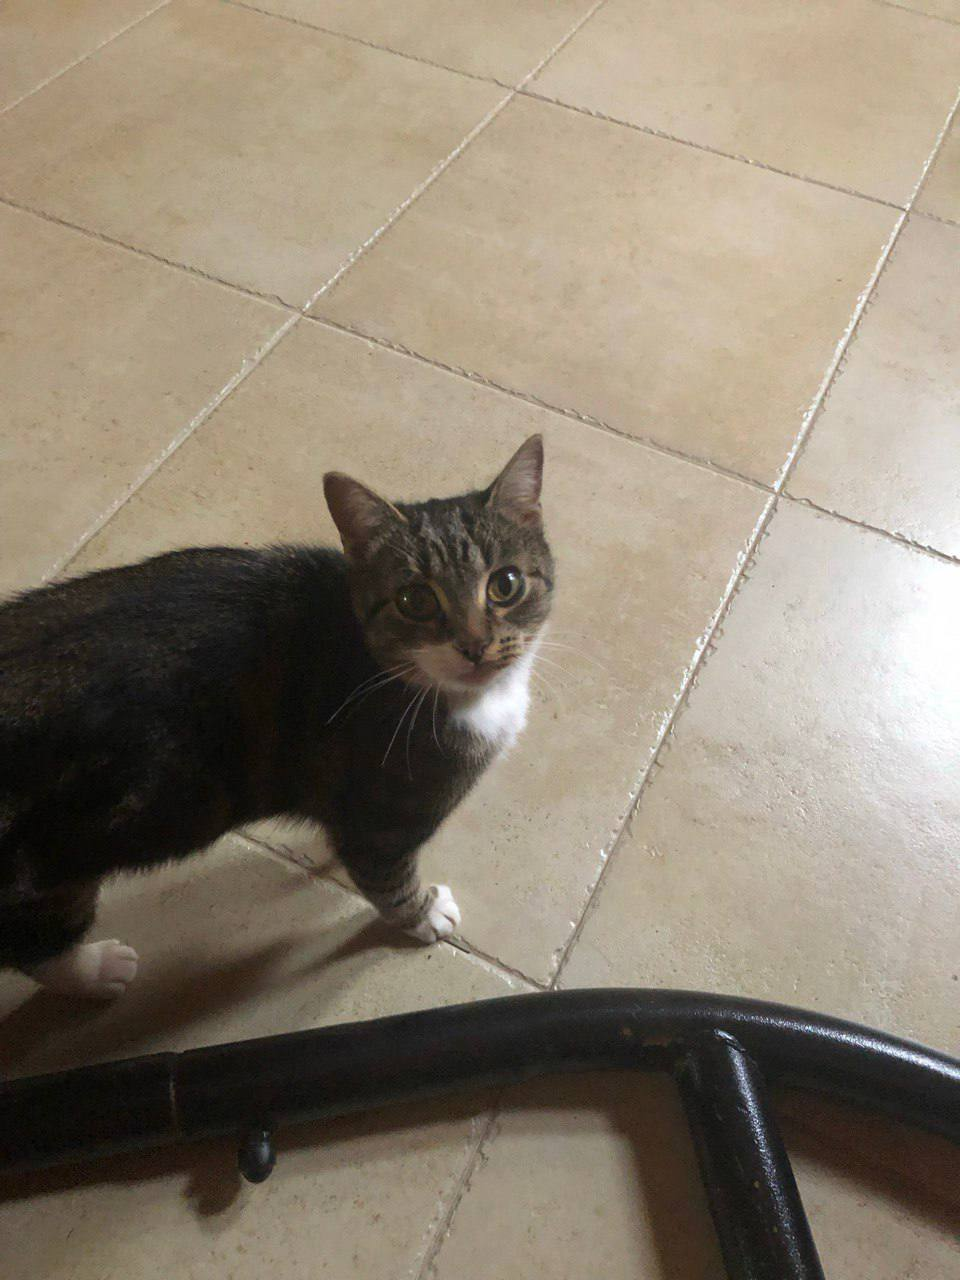